## Alumnos: Pablo Torre e Ignacio Jiménez

##### Basado en código de Tensorflow.org

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generative Adversarial Network

### Setup

In [2]:
import tensorflow as tf

2024-02-25 19:10:59.761755: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-25 19:10:59.786866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 19:10:59.786887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 19:10:59.787457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 19:10:59.791204: I tensorflow/core/platform/cpu_feature_guar

In [3]:
tf.__version__

'2.15.0'

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images) / 255  # Normalize the images to [0, 1]
#plot.imshow normaliza los valores de la imagen antes de mostrarla

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64 # 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

In [9]:
noise_dim = 64

### The Generator


In [10]:
def make_generator_model():

    model = tf.keras.Sequential()

    model.add(layers.Reshape((1,1,64), input_shape=(noise_dim,)))
    model.add(layers.Conv2DTranspose(256, (3,3), strides = 2, use_bias=False))#(3,3,256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())


    model.add(layers.Conv2DTranspose(128, (4, 4), strides = 1, use_bias=False))#(6,6,128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides = 2, use_bias=False))#
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (4, 4), strides = 2, use_bias=False, activation = 'sigmoid'))#


    return model


Use the (as yet untrained) generator to create an image.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 3, 3, 256)         147456    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 3, 3, 256)         1024      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 3, 3, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 6, 6, 128)         524288    
 Transpose)                                                      
                                                        

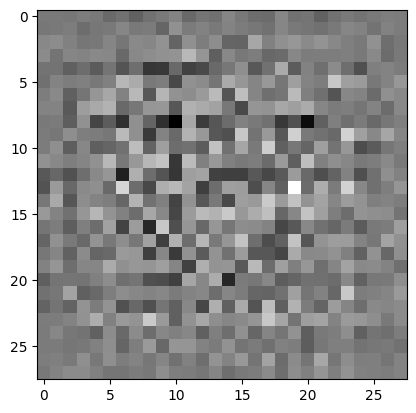

In [11]:
generator = make_generator_model()

print (generator.summary())

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#normaliza los valores de la imagen antes de mostrarla

### The Discriminator


In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(16, (4, 4), strides=2, input_shape = (28, 28,1)))#(26,26,16)
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(32, (4, 4), strides = 2))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(16, (3, 3), strides = 1))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(1, (3, 3), strides =1))
    model.add(layers.Flatten())

    return model


Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [13]:
discriminator = make_discriminator_model()
print (discriminator.summary())
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 13, 16)        272       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 13, 13, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          8224      
                                                                 
 batch_normalization_3 (Bat  (None, 5, 5, 32)          128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 5, 5, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 16)          4624      
                                                      

## Define the loss and optimizers

Define loss functions and optimizers for both models.


### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [14]:
def discriminator_loss(real_output, fake_output):
    fake_loss = tf.reduce_mean(fake_output) 
    real_loss = -tf.reduce_mean(real_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [15]:
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
#generator_optimizer = tf.keras.optimizers.Adam(1e-5)
#discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [17]:
checkpoint_dir = './training_checkpoints_WGAN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [18]:
#EPOCHS = 50 # 50
#noise_dim = 64 #100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [19]:
def gradient_penalty(generated_images, real_images):
    # get the interpolated images
    alpha = tf.random.uniform([real_images.shape[0], 1, 1, 1], 0.0, 1.0)
    diff = generated_images - real_images
    interpolated_images = real_images + alpha * diff

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        # 1. Get the discriminator output for this interpolated images.
        interpolated_output = discriminator(interpolated_images, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated images.`
    grads = tape.gradient(interpolated_output, [interpolated_images])[0]
    # 3. Calculate the norm of the gradients
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0)**2)
    return gp

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, lambda_gp):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as disc_tape:
        # 1. Generate fake images
        generated_images = generator(noise, training=True)
        # 2. Get the discriminator output for the fake images
        fake_output = discriminator(generated_images, training=True)
        
        # 3. Get the discriminator output for the real images
        real_output = discriminator(images, training=True)

        # 4. Calculate the discriminator loss using the fake and real images
        d_loss = discriminator_loss(real_output, fake_output)

        # 5. Calculate the gradient penalty
        gp = gradient_penalty(generated_images, images)

        # 6. Add the gradient penalty to the original discriminator loss
        disc_loss = d_loss + gp * lambda_gp

    # 7. Get the gradients w.r.t the discriminator loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 8. Update the weights of the discriminator using the discriminator optimizer
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
        # 1. Generate fake images
        generated_images = generator(noise, training=True)
        # 2. Get the discriminator output for the fake images
        fake_output = discriminator(generated_images, training=True)
        # 3. Calculate the generator loss
        gen_loss = generator_loss(fake_output)

    # 4. Get the gradients w.r.t the generator loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    # 5. Update the weights of the generator using the generator optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

In [21]:
def train(dataset, epochs, lambda_gp):
    for epoch in range(epochs):
        start = time.time()

        for i, image_batch in enumerate(dataset):
            #print ("len image_batch:", len(image_batch))
            train_step(image_batch, lambda_gp)
            

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

**Generate and save images**


In [22]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0]*255, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.jpeg'.format(epoch),format='jpeg', )
    plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

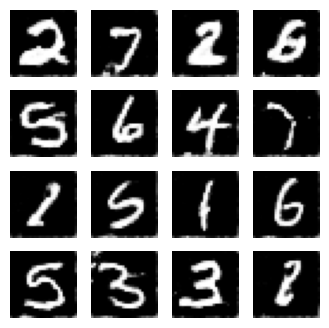

In [24]:
EPOCHS = 100 # 50
train(train_dataset, EPOCHS, lambda_gp = 10)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [25]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.jpeg'.format(epoch_no))

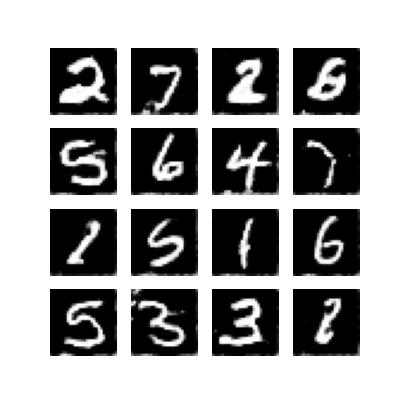

In [26]:
display_image(EPOCHS)

# Conclusiones

Empleando las mismas arquitecturas de redes que DC-GAN, podemos apreciar que la WGAN-GP converge en menos iteraciones, al rededor del epoch 10 ya se empiezan a apreciar los números, y entre el 25 y 35 ya se alcanza la misma calidad que la que pudimos obtener con DC-GAN en 100 epochs. Sin embargo, tiene el inconveniente de que la computación de cada paso es algo más lenta, debido a que realiza más pasos por la red para calcular el gradient penalty. Curiosamente, las imagenes que muestra parecen empeorar a partir del epoch 55-60 en adelante y las imágenes pierden un poco de nitidez.